In [1]:
import kaggle
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import RandomOverSampler


# Show all rows in output
pd.set_option('display.max_rows', 10)
# Show all columns in output
pd.set_option('display.max_columns', 200)

/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
merchants = pd.read_csv('merchants.csv')
users = pd.read_csv('users.csv')
transactions = pd.read_json('transactions.json', lines=True, dtype_backend="numpy_nullable")

# Merge transaction with merchant info
df_combined = transactions.merge(merchants, on='merchant_id', how='left')
# Merge result with user info
df_combined = df_combined.merge(users, on='user_id', how='left')

In [3]:
# Step 1: Group by ID and calculate bad rate
bad_rate_by_id = transactions.groupby('merchant_id')['is_fraud'].agg(['count', 'sum'])
bad_rate_by_id['bad_rate'] = bad_rate_by_id['sum'] / bad_rate_by_id['count']

# Step 2: Sort by bad rate
bad_rate_sorted = bad_rate_by_id.sort_values('bad_rate', ascending=False)

# Step 3: Show top 5 and bottom 5
print("🔝 Top 5 IDs with highest % of bads:")
print(bad_rate_sorted.head(5))

print("\n🔻 Bottom 5 IDs with lowest % of bads:")
print(bad_rate_sorted.tail(5))

🔝 Top 5 IDs with highest % of bads:
             count  sum  bad_rate
merchant_id                      
M0167          570   84  0.147368
M0384          511   75  0.146771
M0916          502   73  0.145418
M0794          534   77  0.144195
M0818          472   68  0.144068

🔻 Bottom 5 IDs with lowest % of bads:
             count  sum  bad_rate
merchant_id                      
M0880          503   20  0.039761
M0699          472   18  0.038136
M0895          510   18  0.035294
M0436          511   17  0.033268
M0110          511   16  0.031311


In [4]:
df_combined['timestamp'] = pd.to_datetime(df_combined['timestamp'])
df_combined['Month_Year_EOM'] = (df_combined['timestamp'] + pd.offsets.MonthEnd(0)).dt.date
df_combined['Date'] = df_combined['timestamp'].dt.strftime('%d-%m-%Y')
df_combined['Year'] = df_combined['timestamp'].dt.strftime('%Y')

def get_part_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    elif 21 <= hour < 23:
        return 'night'
    else:
        return 'late_night'

df_combined['hour'] = df_combined['timestamp'].dt.hour
df_combined['part_of_day'] = df_combined['hour'].apply(get_part_of_day)

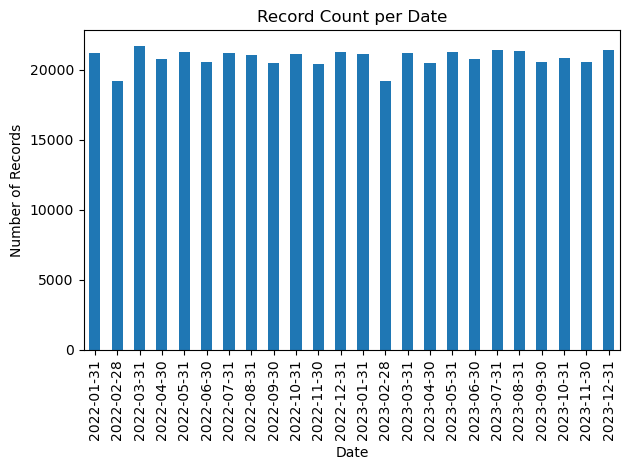

In [5]:
daily_counts = df_combined.groupby('Month_Year_EOM').size()

# Plot
plt.xticks(rotation=90)
daily_counts.plot(kind='bar')  # or use 'line', 'area', etc.
plt.ylabel('Number of Records')
plt.xlabel('Date')
plt.title('Record Count per Date')
plt.tight_layout()
plt.show()

In [6]:
# Dodac rozklad w ciagu dnia fradulent percent
# + monthly
# + dodac kraj transakcji na podstawie long i latt
# +Dodac zmienna ile transakcji w ciagu ostatniej 1h, 6h 
# Dodac zmienna jesli obecna transakcja = wczesniejsza transakcja +-10%, +-5% itd (ile takich transakcji w np. 3h )
# Procentowa róznica wartosci obecnej transakcji w kontekscie do ostatniej (sredniej z ostatnich n transakcji) 


In [7]:
df = df_combined

In [8]:
df = df.sort_values(['user_id', 'timestamp'])

# Create the driver: time difference from previous timestamp per user
df['time_diff'] = df.groupby('user_id')['timestamp'].diff()

In [9]:
df['time_diff_hours'] = (df['time_diff'].dt.total_seconds() / 3600).round(2)
df['latitude'] = df['location'].apply(lambda x: x.get('lat')).round(2)
df['longitude'] = df['location'].apply(lambda x: x.get('long')).round(2)

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers. Use 3956 for miles
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # Distance in kilometers

In [11]:

df = df.sort_values(['user_id', 'timestamp'])

# Shift lat, lon, and timestamp within each user
df['lat_prev'] = df.groupby('user_id')['latitude'].shift()
df['lon_prev'] = df.groupby('user_id')['longitude'].shift()
df['time_prev'] = df.groupby('user_id')['timestamp'].shift()

# Calculate time difference in hours
df['time_diff_hours'] = (df['timestamp'] - df['time_prev']).dt.total_seconds() / 3600

# Calculate distance (only between consecutive positions of the same user)
df['distance_km'] = haversine(df['lat_prev'], df['lon_prev'], df['latitude'], df['longitude'])

# Optional: speed in km/h
df['speed_kmph'] = df['distance_km'] / df['time_diff_hours']

In [12]:
df['amount/avg_amount'] = df['amount'] / df['avg_transaction_amount']
df['amount/sum_monthly_installments'] = df['amount'] / df['sum_of_monthly_installments']
df['amount/sum_monthly_expenses'] = df['amount'] / df['sum_of_monthly_expenses']
df['speed_kmph'] = df['speed_kmph'].clip(upper=2000)
df['countries_same'] = (df['country_x'] == df['country_y']).astype(int)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_bad_percentage_with_plot(df, feature, target):
    """
    Calculates bad rate per category and plots a bar chart.

    Parameters:
    - df: pandas DataFrame
    - feature: categorical column name
    - target: binary column name (1 = bad, 0 = good)

    Returns:
    - summary DataFrame with total, bads, and bad_rate columns
    """
    if feature not in df.columns or target not in df.columns:
        raise ValueError(f"Columns '{feature}' or '{target}' not found in DataFrame.")

    grouped = df.groupby(feature)[target].agg(['count', 'sum']).reset_index()
    grouped.rename(columns={'count': 'total', 'sum': 'bads'}, inplace=True)
    grouped['bad_rate'] = grouped['bads'] / grouped['total']

    # Ensure the bad_rate column exists
    if 'bad_rate' not in grouped.columns:
        raise ValueError("'bad_rate' column was not created. Check input data.")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(grouped[feature].astype(str), grouped['bad_rate'])
    plt.xlabel(feature)
    plt.ylabel('Bad Rate')
    plt.title(f'Bad Rate by {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return grouped

# Example usage:
# result = calculate_bad_percentage_with_plot(data, 'job_type', 'default_flag')

In [14]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,category,country_x,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,age,sex,education,primary_source_of_income,sum_of_monthly_installments,sum_of_monthly_expenses,country_y,signup_date,risk_score,Month_Year_EOM,Date,Year,hour,part_of_day,time_diff,time_diff_hours,latitude,longitude,lat_prev,lon_prev,time_prev,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,countries_same
290822,TX290822,2022-01-08 10:03:00,U00001,M0906,19.09,online,EUR,Web,"{'lat': 69.291741, 'long': -7.72625}",debit_card,1,811,0,0,grocery,Belgium,0.631421,2,26.85,37,0,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-01-31,08-01-2022,2022,10,morning,NaT,NaN,69.29,-7.73,NaN,NaN,NaT,NaN,NaN,0.710987,0.039963,0.078502,0
197951,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,"{'lat': 54.710715, 'long': 15.368695}",mobile_payment,1,233,1,0,gaming,Spain,0.859810,2,197.43,115,1,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-01-31,08-01-2022,2022,16,afternoon,0 days 06:45:00,6.750000,54.71,15.37,69.29,-7.73,2022-01-08 10:03:00,1994.074291,295.418413,0.163298,0.067491,0.132577,0
187979,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,"{'lat': 58.897717, 'long': 30.25543}",debit_card,1,521,1,0,grocery,Spain,0.934815,5,18.36,68,0,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-01-31,12-01-2022,2022,16,afternoon,3 days 23:35:00,95.583333,58.90,30.26,54.71,15.37,2022-01-08 16:48:00,1016.169374,10.631240,0.23366,0.008981,0.017641,0
137034,TX137034,2022-01-18 10:40:00,U00001,M0331,67.0,in-store,EUR,iOS,"{'lat': 42.684202, 'long': 3.843828}",debit_card,1,1149,0,0,gaming,Belgium,0.859404,6,123.91,94,1,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-01-31,18-01-2022,2022,10,morning,5 days 18:17:00,138.283333,42.68,3.84,58.90,30.26,2022-01-12 16:23:00,2556.977104,18.490855,0.540715,0.140258,0.275516,0
401318,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,"{'lat': 44.296089, 'long': 15.749937}",mobile_payment,1,261,1,0,clothing,Germany,0.516453,1,0.98,52,1,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-07-31,18-07-2022,2022,8,morning,180 days 21:25:00,4341.416667,44.30,15.75,42.68,3.84,2022-01-18 10:40:00,976.612531,0.224952,3.663265,0.007515,0.014763,0


In [15]:
drivers = ['channel', 'currency', 'device', 'payment_method', 'is_international', 'is_first_time_merchant',
           'category', 'country_x', 'number_of_alerts_last_6_months', 'has_fraud_history', 'sex', 'education', 'primary_source_of_income',
           'country_y', 'hour', 'part_of_day', 'countries_same'
            ]


In [16]:
# for driver in drivers:
#     calculate_bad_percentage_with_plot(df, driver, 'is_fraud',)

In [17]:
def calculate_bad_rate_for_continuous(df, variable, target, bins=10, binning_method='quantile'):
    """
    Calculates bad rate by binning a continuous variable and plots a bar chart.

    Parameters:
    - df: pandas DataFrame
    - variable: name of the continuous variable
    - target: name of the binary target (1 = bad, 0 = good)
    - bins: number of bins or list of bin edges
    - binning_method: 'quantile' or 'uniform'

    Returns:
    - summary DataFrame with bin, total, bads, bad_rate
    """
    if variable not in df.columns or target not in df.columns:
        raise ValueError(f"Columns '{variable}' or '{target}' not found in DataFrame.")

    if binning_method == 'quantile':
        df['bin'] = pd.qcut(df[variable], q=bins, duplicates='drop')
    elif binning_method == 'uniform':
        df['bin'] = pd.cut(df[variable], bins=bins)
    else:
        raise ValueError("binning_method must be 'quantile' or 'uniform'.")

    grouped = df.groupby('bin')[target].agg(['count', 'sum']).reset_index()
    grouped.rename(columns={'count': 'total', 'sum': 'bads'}, inplace=True)
    grouped['bad_rate'] = grouped['bads'] / grouped['total']

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(grouped['bin'].astype(str), grouped['bad_rate'])
    plt.xlabel(f'{variable} bins')
    plt.ylabel('Bad Rate')
    plt.title(f'Bad Rate by Binned {variable}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return grouped

# Example usage:
# result = calculate_bad_rate_for_continuous(data, 'income', 'default_flag', bins=5)

In [18]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,category,country_x,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,age,sex,education,primary_source_of_income,sum_of_monthly_installments,sum_of_monthly_expenses,country_y,signup_date,risk_score,Month_Year_EOM,Date,Year,hour,part_of_day,time_diff,time_diff_hours,latitude,longitude,lat_prev,lon_prev,time_prev,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,countries_same
290822,TX290822,2022-01-08 10:03:00,U00001,M0906,19.09,online,EUR,Web,"{'lat': 69.291741, 'long': -7.72625}",debit_card,1,811,0,0,grocery,Belgium,0.631421,2,26.85,37,0,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-01-31,08-01-2022,2022,10,morning,NaT,NaN,69.29,-7.73,NaN,NaN,NaT,NaN,NaN,0.710987,0.039963,0.078502,0
197951,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,"{'lat': 54.710715, 'long': 15.368695}",mobile_payment,1,233,1,0,gaming,Spain,0.859810,2,197.43,115,1,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-01-31,08-01-2022,2022,16,afternoon,0 days 06:45:00,6.750000,54.71,15.37,69.29,-7.73,2022-01-08 10:03:00,1994.074291,295.418413,0.163298,0.067491,0.132577,0
187979,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,"{'lat': 58.897717, 'long': 30.25543}",debit_card,1,521,1,0,grocery,Spain,0.934815,5,18.36,68,0,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-01-31,12-01-2022,2022,16,afternoon,3 days 23:35:00,95.583333,58.90,30.26,54.71,15.37,2022-01-08 16:48:00,1016.169374,10.631240,0.23366,0.008981,0.017641,0
137034,TX137034,2022-01-18 10:40:00,U00001,M0331,67.0,in-store,EUR,iOS,"{'lat': 42.684202, 'long': 3.843828}",debit_card,1,1149,0,0,gaming,Belgium,0.859404,6,123.91,94,1,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-01-31,18-01-2022,2022,10,morning,5 days 18:17:00,138.283333,42.68,3.84,58.90,30.26,2022-01-12 16:23:00,2556.977104,18.490855,0.540715,0.140258,0.275516,0
401318,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,"{'lat': 44.296089, 'long': 15.749937}",mobile_payment,1,261,1,0,clothing,Germany,0.516453,1,0.98,52,1,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079,2022-07-31,18-07-2022,2022,8,morning,180 days 21:25:00,4341.416667,44.30,15.75,42.68,3.84,2022-01-18 10:40:00,976.612531,0.224952,3.663265,0.007515,0.014763,0


In [19]:
drivers = [ 'amount', 'session_length_seconds', 'trust_score', 'avg_transaction_amount',  'account_age_months', 'age', 
                'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'risk_score', 'time_diff_hours', 'distance_km', 
            'speed_kmph', 'amount/avg_amount', 'amount/sum_monthly_installments', 'amount/sum_monthly_expenses', 
]

In [20]:
# for driver in drivers:
#     calculate_bad_rate_for_continuous(df, driver, 'is_fraud', bins=20)

In [21]:
import pandas as pd

# Ensure the timestamp column is in datetime format and data is sorted
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by=['user_id', 'timestamp'])

# Define rolling windows (feature names and window durations)
window_sizes = {
    'tx_last_15min': '15min',
    'tx_last_1h': '1h',
    'tx_last_6h': '6h',
    'tx_last_12h': '12h'
}

# Container for processed user groups
processed_groups = []

# Apply rolling transaction counts per user
for user_id, group in df.groupby('user_id'):
    group = group.copy()
    group = group.set_index('timestamp')

    for col, window in window_sizes.items():
        group[col] = (
            group['user_id']
            .rolling(window=window)
            .count()
            .shift(1)  # exclude the current transaction
            .fillna(0)
            .astype(int)
        )

    group = group.reset_index()  # Restore 'timestamp' as a column
    processed_groups.append(group)

# Concatenate all groups back into one final DataFrame
df_final = pd.concat(processed_groups, ignore_index=True)

# Optional: check the result
print(df_final[['user_id', 'timestamp'] + list(window_sizes.keys())].head())

  user_id           timestamp  tx_last_15min  tx_last_1h  tx_last_6h  \
0  U00001 2022-01-08 10:03:00              0           0           0   
1  U00001 2022-01-08 16:48:00              1           1           1   
2  U00001 2022-01-12 16:23:00              1           1           1   
3  U00001 2022-01-18 10:40:00              1           1           1   
4  U00001 2022-07-18 08:05:00              1           1           1   

   tx_last_12h  
0            0  
1            1  
2            2  
3            1  
4            1  


In [25]:
# Select only the new rolling features from df_final
rolling_features = df_final[['tx_last_15min', 'tx_last_1h', 'tx_last_6h', 'tx_last_12h']]

# Combine them with the original df (must have same index/order)
df = df.reset_index(drop=True)  # ensure clean index
df = pd.concat([df, rolling_features], axis=1)

In [26]:
# Get index of earliest timestamp for each user_id
first_idx = df.sort_values(by=['user_id', 'timestamp']).groupby('user_id').head(1).index

# Drop those rows
df = df.drop(index=first_idx)


In [28]:
test_df = df
to_drop = ['transaction_id', 'user_id', 'currency' , 'location', 'bin']
numeric = ['amount', 'is_international', 'session_length_seconds' , 'is_first_time_merchant', 'trust_score', 'number_of_alerts_last_6_months',
           'avg_transaction_amount', 'account_age_months' ,'age', 'sum_of_monthly_installments', 'sum_of_monthly_expenses',
           'risk_score', 'time_diff_hours', 'distance_km', 'has_fraud_history', 'tx_last_15min', 'tx_last_1h', 'tx_last_6h', 'tx_last_12h',
           'amount/avg_amount', 'amount/sum_monthly_installments', 'amount/sum_monthly_expenses', 'hour', 'speed_kmph', 'countries_same'] 
to_categorize = ['channel', 'device', 'payment_method' , 'category', 'country_x', 'sex', 
                 'education', 'primary_source_of_income', 'country_y', 'part_of_day',
                 
                   ]
to_think_but_drop = ['signup_date', 'Month_Year_EOM', 'Date', 'Year', 'time_diff', 'time_prev' , 'latitude', 'longitude' ,'lat_prev', 'lon_prev', 
                     ]
target = 'is_fraud'
test_df = test_df.drop(to_drop, axis =1)
test_df = test_df.drop(numeric, axis =1)
test_df = test_df.drop(to_think_but_drop, axis =1)
test_df = test_df.drop(to_categorize, axis =1)

In [29]:
df = df.drop(to_drop, axis = 1)
df = df.drop(to_think_but_drop, axis =1 )
df = pd.get_dummies(df, columns=to_categorize)

In [30]:
df.corr()['is_fraud'].sort_values()

ValueError: could not convert string to float: 'M0245'

In [31]:
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

In [32]:
cutoff = pd.to_datetime('2023-07-01')

# Split the data
df_train = df[df['timestamp'] < cutoff]
df_test = df[df['timestamp'] >= cutoff]
df_train = df_train.drop('timestamp', axis = 1 )
df_test = df_test.drop('timestamp', axis = 1 )
X_train = df_train.drop('is_fraud', axis = 1 )
y_train = df_train['is_fraud']
X_test = df_test.drop('is_fraud', axis = 1 )
y_test = df_test['is_fraud']

In [33]:
bad_rate_per_merchant = (
    df.groupby('merchant_id')['is_fraud']
    .agg(total_transactions='count', num_frauds='sum')
)

In [34]:
bad_rate_per_merchant['bad_rate'] = (
    bad_rate_per_merchant['num_frauds'] / bad_rate_per_merchant['total_transactions']
)

In [35]:
X_train = X_train.merge(bad_rate_per_merchant, on='merchant_id', how='left')
X_test = X_test.merge(bad_rate_per_merchant, on='merchant_id', how='left')


In [36]:
X_train = X_train.drop('merchant_id', axis = 1)
X_test = X_test.drop('merchant_id', axis = 1)

In [37]:
X_train

,amount,is_international,session_length_seconds,is_first_time_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,age,sum_of_monthly_installments,sum_of_monthly_expenses,risk_score,hour,time_diff_hours,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,countries_same,tx_last_15min,tx_last_1h,tx_last_6h,tx_last_12h,tx_last_15min,tx_last_1h,tx_last_6h,tx_last_12h,channel_in-store,channel_mobile,channel_online,device_Android,device_Web,device_iOS,payment_method_bank_transfer,payment_method_credit_card,payment_method_debit_card,payment_method_mobile_payment,category_clothing,category_education,category_electronics,category_gaming,category_grocery,category_restaurants,category_travel,country_x_Austria,country_x_Belgium,country_x_Czech Republic,country_x_Denmark,country_x_Finland,country_x_France,country_x_Germany,country_x_Ireland,country_x_Italy,country_x_Netherlands,country_x_Poland,country_x_Portugal,country_x_Spain,country_x_Sweden,sex_Female,sex_Male,sex_Other,education_Bachelor,education_High School,education_Master,education_PhD,primary_source_of_income_Business,primary_source_of_income_Employment,primary_source_of_income_Retirement,primary_source_of_income_Savings,primary_source_of_income_Student Aid,primary_source_of_income_Unemployment,country_y_Austria,country_y_Belgium,country_y_Czech Republic,country_y_Denmark,country_y_Finland,country_y_France,country_y_Germany,country_y_Ireland,country_y_Italy,country_y_Netherlands,country_y_Poland,country_y_Portugal,country_y_Spain,country_y_Sweden,part_of_day_afternoon,part_of_day_evening,part_of_day_late_night,part_of_day_morning,part_of_day_night,total_transactions,num_frauds,bad_rate
0,32.24,1,233,1,0.859810,2,197.43,115,1,56,477.69,243.18,0.571079,16,6.750000,1994.074291,295.418413,0.163298,0.067491,0.132577,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,467,43,0.092077
1,4.29,1,521,1,0.934815,5,18.36,68,0,56,477.69,243.18,0.571079,16,95.583333,1016.169374,10.631240,0.23366,0.008981,0.017641,0,1,1,1,2,1,1,1,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,474,30,0.063291
2,67.0,1,1149,0,0.859404,6,123.91,94,1,56,477.69,243.18,0.571079,10,138.283333,2556.977104,18.490855,0.540715,0.140258,0.275516,0,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,481,56,0.116424
3,3.59,1,261,1,0.516453,1,0.98,52,1,56,477.69,243.18,0.571079,8,4341.416667,976.612531,0.224952,3.663265,0.007515,0.014763,0,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,450,46,0.102222
4,22.94,1,426,0,0.816480,3,21.19,53,1,56,477.69,243.18,0.571079,12,532.416667,1039.774561,1.952934,1.082586,0.048023,0.094333,0,1,1,1,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,499,50,0.1002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354052,144.52,1,519,1,0.857549,0,82.35,82,1,50,52.07,211.52,0.607373,15,91.550000,2223.301432,24.285106,1.754948,2.775495,0.683245,0,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,466,43,0.092275
354053,29.51,1,1030,0,0.798217,5,9.37,44,0,50,52.07,211.52,0.607373,3,516.366667,2482.155009,4.806962,3.149413,0.566737,0.139514

In [ ]:
# df = df.drop('timestamp', axis = 1)
# X = df.drop('is_fraud', axis = 1 )
# y = df['is_fraud']

KeyError: "['timestamp'] not found in axis"

In [ ]:
# from sklearn.model_selection import train_test_split

# # Split data (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )


In [38]:
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

In [39]:
# mozna dodac scale _pos_weight option
y_test.value_counts()

is_fraud
0    115152
1     10791
Name: count, dtype: Int64

In [40]:
X_train_oversampled


,amount,is_international,session_length_seconds,is_first_time_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,age,sum_of_monthly_installments,sum_of_monthly_expenses,risk_score,hour,time_diff_hours,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,countries_same,tx_last_15min,tx_last_1h,tx_last_6h,tx_last_12h,tx_last_15min,tx_last_1h,tx_last_6h,tx_last_12h,channel_in-store,channel_mobile,channel_online,device_Android,device_Web,device_iOS,payment_method_bank_transfer,payment_method_credit_card,payment_method_debit_card,payment_method_mobile_payment,category_clothing,category_education,category_electronics,category_gaming,category_grocery,category_restaurants,category_travel,country_x_Austria,country_x_Belgium,country_x_Czech Republic,country_x_Denmark,country_x_Finland,country_x_France,country_x_Germany,country_x_Ireland,country_x_Italy,country_x_Netherlands,country_x_Poland,country_x_Portugal,country_x_Spain,country_x_Sweden,sex_Female,sex_Male,sex_Other,education_Bachelor,education_High School,education_Master,education_PhD,primary_source_of_income_Business,primary_source_of_income_Employment,primary_source_of_income_Retirement,primary_source_of_income_Savings,primary_source_of_income_Student Aid,primary_source_of_income_Unemployment,country_y_Austria,country_y_Belgium,country_y_Czech Republic,country_y_Denmark,country_y_Finland,country_y_France,country_y_Germany,country_y_Ireland,country_y_Italy,country_y_Netherlands,country_y_Poland,country_y_Portugal,country_y_Spain,country_y_Sweden,part_of_day_afternoon,part_of_day_evening,part_of_day_late_night,part_of_day_morning,part_of_day_night,total_transactions,num_frauds,bad_rate
0,32.24,1,233,1,0.859810,2,197.43,115,1,56,477.69,243.18,0.571079,16,6.750000,1994.074291,295.418413,0.163298,0.067491,0.132577,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,467,43,0.092077
1,4.29,1,521,1,0.934815,5,18.36,68,0,56,477.69,243.18,0.571079,16,95.583333,1016.169374,10.631240,0.23366,0.008981,0.017641,0,1,1,1,2,1,1,1,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,474,30,0.063291
2,67.0,1,1149,0,0.859404,6,123.91,94,1,56,477.69,243.18,0.571079,10,138.283333,2556.977104,18.490855,0.540715,0.140258,0.275516,0,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,481,56,0.116424
3,3.59,1,261,1,0.516453,1,0.98,52,1,56,477.69,243.18,0.571079,8,4341.416667,976.612531,0.224952,3.663265,0.007515,0.014763,0,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,450,46,0.102222
4,22.94,1,426,0,0.816480,3,21.19,53,1,56,477.69,243.18,0.571079,12,532.416667,1039.774561,1.952934,1.082586,0.048023,0.094333,0,1,1,1,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,499,50,0.1002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648345,4.22,1,704,0,0.446582,3,96.21,22,1,48,774.05,2805.81,0.463343,14,233.416667,2155.602343,9.234998,0.043862,0.005452,0.001504,0,1,1,1,1,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,469,48,0.102345
648346,35.36,1,924,1,0.657387,5,216.18,36,1,67,677.75,2878.59,0.670343,14,154.966667,2466.582325,15.916857,0.163567,0.052173,0.0

In [41]:
# 2. Train XGBoost
model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.5,
    colsample_bytree=0.8,
    reg_alpha=1,         # L1 regularization
    reg_lambda=10,       # L2 regularization
    use_label_encoder=False,   
    eval_metric='auc',
    random_state=42
)

model.fit(
    X_train_oversampled, y_train_oversampled
)


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [42]:
y_proba_test = model.predict_proba(X_test)[:, 1]
y_proba_train = model.predict_proba(X_train_oversampled)[:, 1]
y_proba_train_orig = model.predict_proba(X_train)[:, 1]  # <-- original X_train before oversampling

# Calculate AUC scores
auc_test = roc_auc_score(y_test, y_proba_test)
auc_train = roc_auc_score(y_train_oversampled, y_proba_train)
auc_train_orig = roc_auc_score(y_train, y_proba_train_orig)

print(f"ROC AUC Score (Test): {auc_test:.4f}")
print(f"ROC AUC Score (Train): {auc_train:.4f}")
print(f"ROC AUC Score (Train on original): {auc_train_orig:.4f}")

# Get ROC curve values
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_train_oversampled, y_proba_train)
fpr_train_orig, tpr_train_orig, _ = roc_curve(y_train, y_proba_train_orig)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}', linestyle='--')
plt.plot(fpr_train_orig, tpr_train_orig, label=f'Train AUC (orig) = {auc_train_orig:.2f}', linestyle='-')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train vs Test)')
plt.legend()
plt.grid(True)
plt.show()

NotFittedError: need to call fit or load_model beforehand

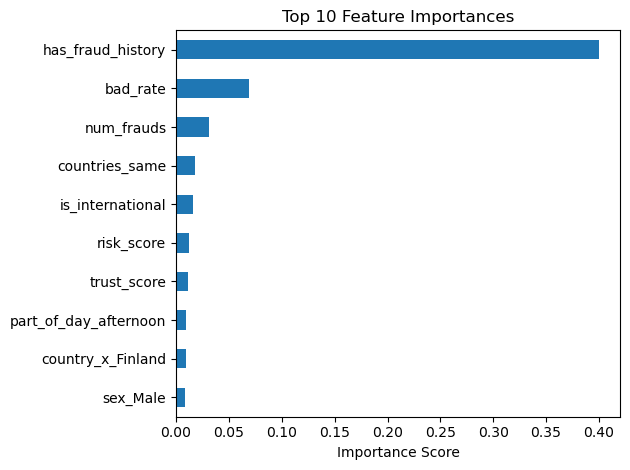

In [159]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.sort_values(ascending=False).head(10)

top_10_features.plot(kind='barh', title='Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [160]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)



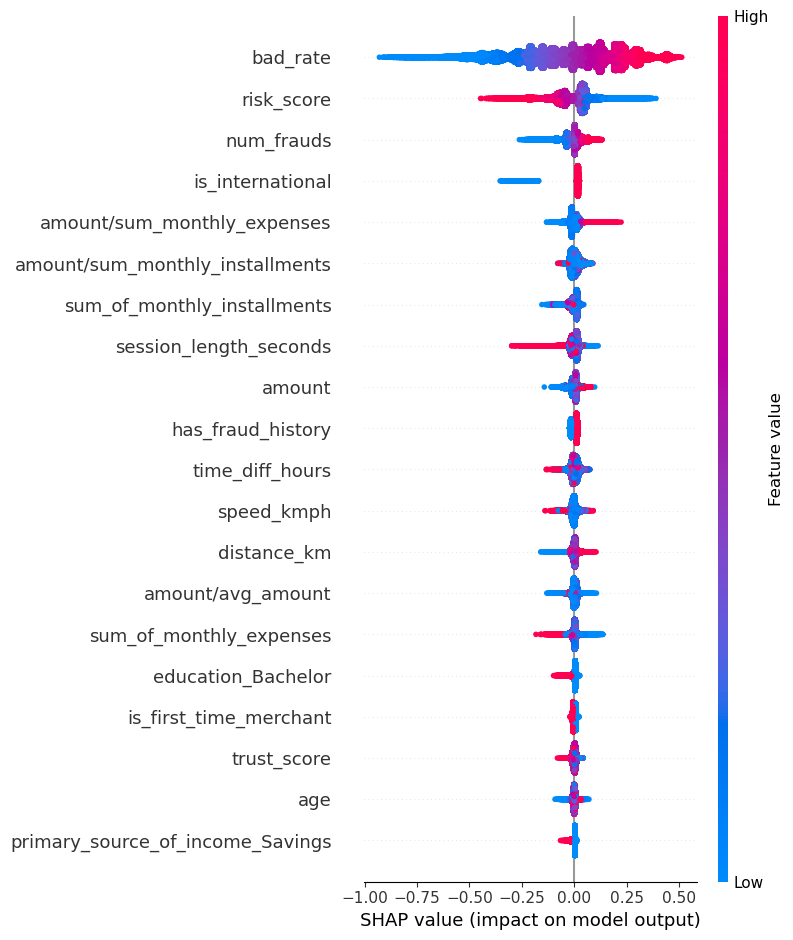

In [161]:

# Summary plot (feature importance)
shap.summary_plot(shap_values, X_test)


In [162]:

# 4. Identify top 3 most important features
shap_importance = np.abs(shap_values.values).mean(axis=0)
top3_features = X_train.columns[np.argsort(shap_importance)[-3:][::-1]].tolist()
print("Top 3 features based on SHAP:", top3_features)

Top 3 features based on SHAP: ['bad_rate', 'risk_score', 'num_frauds']


In [163]:
top3_features = ['bad_rate','trust_score','risk_score', 'amount/sum_monthly_installments', 'sum_of_monthly_installments']

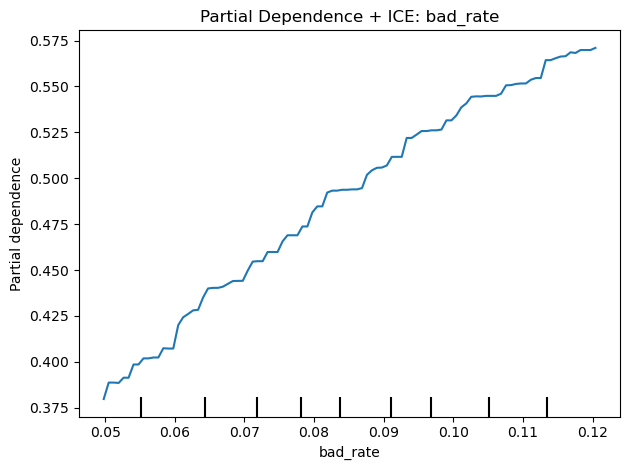

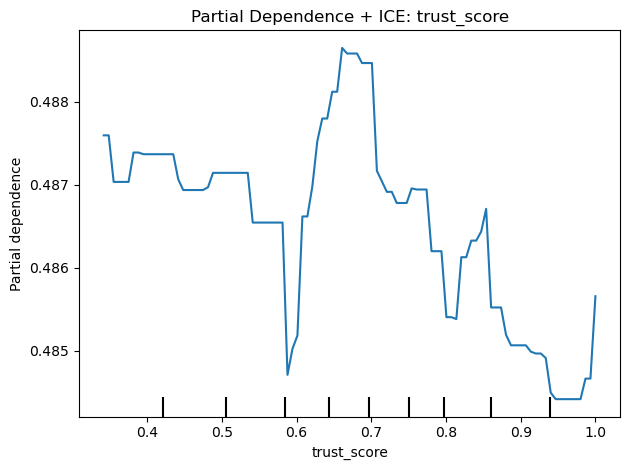

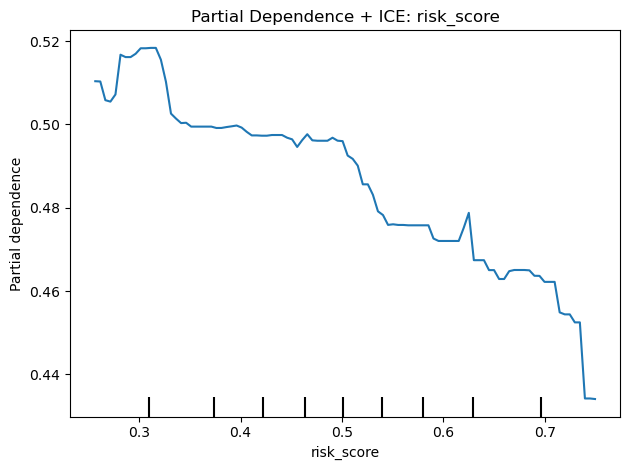

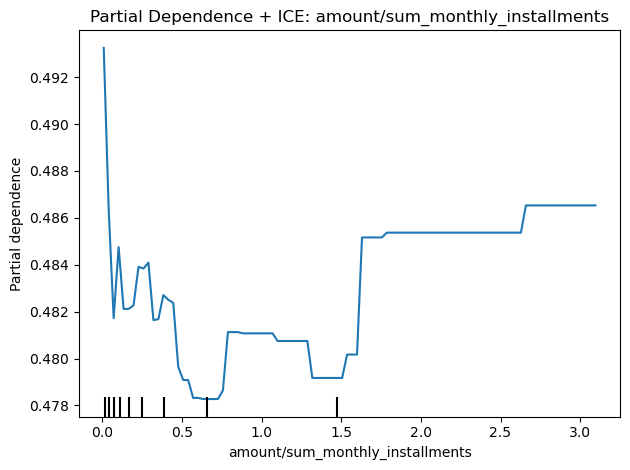

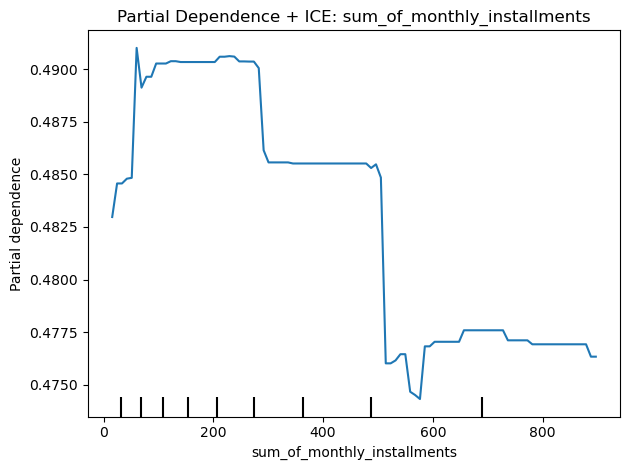

In [165]:

for feature in top3_features:
    display = PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        [feature],          # must be a list
        # kind='both',        # PDP + ICE curves
        # grid_resolution=30, # smoother curves
        # subsample=100,      # limit ICE lines to 100 samples
        random_state=42     # for reproducibility
    )
    plt.title(f'Partial Dependence + ICE: {feature}')
    plt.tight_layout()
    plt.show()

In [166]:

# 6. Permutation Importance
perm = permutation_importance(model, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values(by='importance_mean', ascending=False)

print("Permutation Importance:")
print(perm_df.head(10))

Permutation Importance:
                            feature  importance_mean  importance_std
86                         bad_rate         0.054576        0.003596
12                       risk_score         0.007672        0.000648
1                  is_international         0.003556        0.000513
85                       num_frauds         0.001694        0.000545
18  amount/sum_monthly_installments         0.000546        0.000315
2            session_length_seconds         0.000534        0.000215
0                            amount         0.000460        0.000205
4                       trust_score         0.000278        0.000112
10      sum_of_monthly_installments         0.000142        0.000303
16                       speed_kmph         0.000139        0.000197
